In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

df_plan_metro = pd.read_csv('data/plan du métro corrigé.csv')
df_position_gps = pd.read_csv('data/position gps des stations de métro.csv')
df_passagers = pd.read_csv('data/passagers.csv')
df_sup_stations = pd.read_csv('data/position gps manquantes.csv', sep=';')

# Data preparation

### station_coords
- longitude: float
- latitude: float
- lignes: list(int)

In [2]:
# Dataframe of the gps coordinates of the stations
station_coords = df_position_gps.copy()
station_coords['latitude'] = df_position_gps['GPS'].str.split(',').str[0]
station_coords['longitude'] = df_position_gps['GPS'].str.split(',').str[1]
station_coords.drop('GPS', axis=1, inplace=True)
station_coords = station_coords.drop_duplicates(subset="Station", keep="first")

# However 46 gps coords are missing, we add it through a hand-made csv
sup_stations = df_sup_stations.copy()
sup_stations.drop('ligne', axis=1, inplace=True)
station_coords = pd.concat([station_coords, sup_stations], ignore_index=True)
station_coords['latitude'] = station_coords['latitude'].astype(float)
station_coords['longitude'] = station_coords['longitude'].astype(float)

In [3]:
num_stations = station_coords.shape[0]
num_lines = 14
print(f"There is {station_coords.shape[0]} metro stations and {num_lines} lines.")

There is 307 metro stations and 14 lines.


In [4]:
def get_index(station_name):
  return station_coords[station_coords['Station'] == station_name].index[0]

def get_station_name(index):
  return station_coords.iloc[index,0]

# Fonction personnalisée pour la conversion
def convert_metro_line(val):
    # Si 'bis' est dans la valeur, retirer 'bis' et convertir en entier
    if 'bis' in val:
        return int(val.replace('bis', '').strip())
    # Sinon, convertir directement en entier
    return int(val)

In [5]:
# Get the lines going through each station
metro_de = df_plan_metro.copy()
metro_de = metro_de.iloc[:,0:2]
metro_de = metro_de.rename(columns={'de Ligne':'Ligne', 'de Station':'Station'})

metro_vers = df_plan_metro.copy()
metro_vers = df_plan_metro.iloc[:,2:4]
metro_vers = metro_vers.rename(columns={'vers Ligne':'Ligne', 'vers Station':'Station'})

metro_line = pd.concat([metro_de,metro_vers],axis=0)
metro_line.drop_duplicates(subset=['Ligne','Station'],keep='first',ignore_index=True, inplace=True)
metro_line['Ligne'] = metro_line['Ligne'].apply(convert_metro_line)

station_line_list =[[] for _ in range(num_stations)]
for i in range (metro_line.shape[0]):
    line = metro_line.iloc[i,0]
    station = metro_line.iloc[i,1]
    station_index = get_index(station)
    station_line_list[station_index].append(line)

# Add these information in station_coords
station_coords['lines'] = station_line_list

# Correct wrong gps coords
station_coords.iloc[122,1] = 48.8828400216298
station_coords.iloc[122,2] = 2.30948784696001

station_coords.head()

,Station,latitude,longitude,lines
0,Boucicaut,48.841094,2.287946,[8]
1,Bourse,48.868654,2.341376,[3]
2,Bir-Hakeim,48.853943,2.289335,[6]
3,Argentine,48.875337,2.290128,[1]
4,Daumesnil,48.839550,2.395703,"[6, 8]"


# Class MetroNetwork

In [6]:
class MetroNetwork:
    def __init__(self, station_coords, station_line_list, plan_metro):
        self.station_coords = station_coords
        self.station_line_list = station_line_list
        self.plan_metro = plan_metro
        self.adjacency_matrix = self.build_adjacency_matrix()
        self.edges = self.build_edges()


    
    def build_edges(self):
        station_single_line = self.plan_metro[self.plan_metro['de Station'] != self.plan_metro['vers Station']]
        edges = station_single_line.copy()
        edges = edges.reset_index()
        edges = edges.drop(columns=['index','de Ligne','vers Ligne'])
        edges['de Station'] = edges['de Station'].apply(get_index)
        edges['vers Station'] = edges['vers Station'].apply(get_index)
        edges['flow'] = [0]*edges.shape[0]

        return edges


    def build_adjacency_matrix(self):
        station_single_line = self.plan_metro[self.plan_metro['de Station'] != self.plan_metro['vers Station']]
        station_single_line['de Ligne'] = self.plan_metro['de Ligne']
        m = station_single_line.shape[0]
        adjacency_matrix = np.zeros((m,m))
        for i in range(m):
            index_depart = get_index(station_single_line.iloc[i,1])
            index_arrivee = get_index(station_single_line.iloc[i,3])
            adjacency_matrix[index_depart,index_arrivee] = 1
        
        return adjacency_matrix
     

    def distance(self, station_index1, station_index2):
        lat1 = self.station_coords.iloc[station_index1,1]
        lon1 = self.station_coords.iloc[station_index1,2]
        lat2 = self.station_coords.iloc[station_index2,1]
        lon2 = self.station_coords.iloc[station_index2,2]
        return sqrt((lat1-lat2)**2 + (lon1-lon2)**2)
    

    def shared_line(self, station1, stationi):
        for line_1 in self.station_line_list[station1]:
            for line_i in self.station_line_list[stationi]:
                if line_1 == line_i:
                    return line_1
                
    def get_station_line_of(self, station_index):
        """return: list(int), lines of the station"""
        return self.station_line_list[station_index]
    

    def reset_num_passagers(self):
        self.edges['flow'] = 0

                

    def get_adjacent_stations(self, station1, traveled_distance, station2, route):
        """
        station1: int, departure station index
        traveled_distance: float, distance parcourue pour arriver à station1
        station2: int, arrival station index
        route: list, stations visitées pour arriver à station1
        """

        adjacent_stations = pd.DataFrame(columns=['station', 'traveled_distance','distance_to_station2','cout','route','sation_name'])


        for station_i in range(num_stations):
            #Select the stations adjacent to station1
            if self.adjacency_matrix[station1,station_i] != 0:
                route_i = route.copy()
                #Compute distances from station1 to station i and station2
                new_traveled_distance = traveled_distance + self.distance(station1,station_i)
                distance_to_station2 = self.distance(station_i,station2)

                # add a malus if a line change is needed
                current_line = route_i.iloc[route_i.shape[0]-1,1]
                if current_line in self.get_station_line_of(station_i):
                    new_line = current_line
                else:
                    new_line = self.shared_line(station1,station_i)
                    new_traveled_distance += 0.1 # the distance between two station is around 0.01 (around 1 minute), we suppose that a line change is around 10 minutes, that's why we add 0.1 distance
                    
                #Add the station to the route_i
                route_i.loc[len(route_i)] = [station_i, new_line]

                self.adjacency_matrix[station1,station_i] = 0

                #Add station i and his parameters to potential next stations to explore
                adjacent_stations = pd.concat([adjacent_stations,
                                                pd.DataFrame({'station': [station_i],
                                                            'traveled_distance': [new_traveled_distance],
                                                            'distance_to_station2': [distance_to_station2],
                                                            'cout': [(new_traveled_distance + distance_to_station2)],
                                                            'route': [route_i]
                                                            })], ignore_index=True)
        return adjacent_stations
    

    def trouver_trajets(self, station1, station2, traveled_distance, route, next_stations):
        """
        station1: int, departure station index
        station2: int, arrival station index
        traveled_distance: float, distance traveled to reach station1
        route: list, stations already seen
        next_stations: dataframe, stations to visit with the traveled distance to reach them
        """

        adjacent_stations = self.get_adjacent_stations(station1, traveled_distance, station2, route)

        #add the adjacent stations to station to visit
        new_next_stations = pd.concat([next_stations, adjacent_stations], ignore_index=True).sort_values(by='cout',ascending=True,ignore_index=True).drop_duplicates('station', keep="first",ignore_index=True)

        # compute the station that bring the closest to station2
        new_station1= new_next_stations.iloc[0,0]
        new_traveled_distance = new_next_stations.iloc[0,1]
        new_route = new_next_stations.iloc[0,4]


        #drop the new station from next stations possible
        new_next_stations = new_next_stations.drop(index = 0) #maybe just delete index0

        if new_station1 == station2:
            new_route['station'] = new_route['station'].apply(get_station_name)
            return new_route
        
        else:
            return self.trouver_trajets(new_station1, station2, new_traveled_distance, new_route, new_next_stations)
        
    
    def predict_route(self, station1_name,station2_name):
        self.adjacency_matrix = self.build_adjacency_matrix()
        next_stations_init = pd.DataFrame(columns=['station', 'traveled_distance','distance_to_station2', 'cout','route'])
        station_index1 = get_index(station1_name)
        station_index2 = get_index(station2_name)
        result =  self.trouver_trajets(station_index1, station_index2,0,pd.DataFrame({'station': station_index1, 'line': self.get_station_line_of(station_index1)[0]}, index=[0]),next_stations_init)
        self.adjacency_matrix = self.build_adjacency_matrix()
        return result

# Test

In [7]:
MetroParis = MetroNetwork(station_coords,station_line_list,df_plan_metro)

In [8]:
MetroParis.predict_route('La Défense','Pont de Levallois - Bécon')

,station,line
0,La Défense,1
1,Esplanade de La Défense,1
2,Pont de Neuilly,1
3,Les Sablons,1
4,Porte Maillot,1
5,Argentine,1
6,Charles de Gaulle - Étoile,1
7,Ternes,2
8,Courcelles,2
9,Monceau,2


In [ ]:
MetroParis.reset_num_passagers()
passagers = df_passagers.copy()
#df_passagers.shape[0]
for i in tqdm(range(df_passagers.shape[0])):
    station_depart = passagers.iloc[i,0]
    station_arrivee = passagers.iloc[i,1]
    num_passagers = passagers.iloc[i,2]

    route = MetroParis.predict_route(station_depart,station_arrivee)
    # print(num_passagers)
    # print(route)
    route = route['station'].apply(get_index)
    route = route.to_numpy()

    for j in range(route.shape[0]-1):
        edge = np.array([route[j],route[j+1]])
        index_route = MetroParis.edges[(MetroParis.edges['de Station'] == route[j]) & (MetroParis.edges['vers Station'] == route[j+1])].index[0]
        MetroParis.edges.loc[index_route,'flow'] += num_passagers

# GeoPandas (test)

In [ ]:
pip install geopandas

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [ ]:
# Convertir les coordonnées en objets géométriques
geometry = gpd.points_from_xy(station_coords['longitude'], station_coords['latitude'])

# Créer un GeoDataFrame
stations_gdf = gpd.GeoDataFrame(station_coords, geometry=geometry)

# Vérifier les données
print(stations_gdf)

                              Station   latitude  longitude   lines  \
0                           Boucicaut  48.841094   2.287946     [8]   
1                              Bourse  48.868654   2.341376     [3]   
2                          Bir-Hakeim  48.853943   2.289335     [6]   
3                           Argentine  48.875337   2.290128     [1]   
4                           Daumesnil  48.839550   2.395703  [6, 8]   
..                                ...        ...        ...     ...   
302                   Sully - Morland  48.851271   2.361853     [7]   
303             Barbès - Rochechouart  48.883776   2.350607  [2, 4]   
304                 Pré-Saint-Gervais  48.880160   2.398581  [7, 8]   
305                  Quatre-Septembre  48.869659   2.336319     [3]   
306  Maisons-Alfort - Les Juilliottes  48.803106   2.445788     [8]   

                     geometry  
0    POINT (2.28795 48.84109)  
1    POINT (2.34138 48.86865)  
2    POINT (2.28933 48.85394)  
3    POINT (2.29013

In [108]:
def first_element(l):
    return l[0]

color = stations_gdf['lines'].apply(first_element)
print(color)

0      8
1      3
2      6
3      1
4      6
      ..
302    7
303    2
304    7
305    3
306    8
Name: lines, Length: 307, dtype: int64


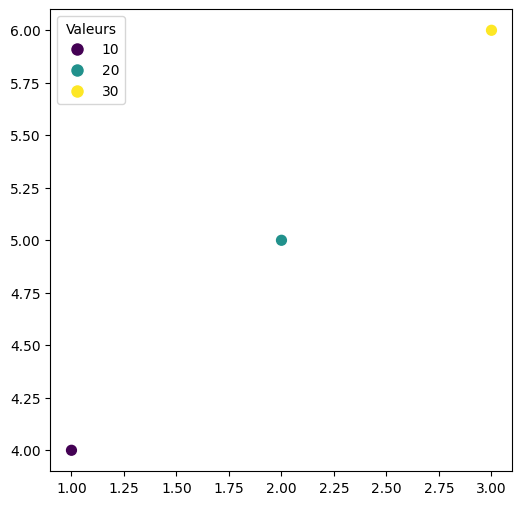

In [117]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Exemple : gdf avec des coordonnées géographiques
stations_gdf = gpd.GeoDataFrame({
    'geometry': gpd.points_from_xy([1, 2, 3], [4, 5, 6]),
    'value': [10, 20, 30]
})

# Configurer la figure et l'axe
fig, ax = plt.subplots(figsize=(8, 6))

# Tracer les points avec les couleurs associées
stations_gdf.plot(ax=ax, marker='o', c=color, markersize=50)

# Ajouter une légende manuelle
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(val)), markersize=10, label=f"{val}")
    for val in sorted(color.unique())
]
ax.legend(handles=legend_elements, title="Valeurs")

# Montrer le graphique
plt.show()


In [ ]:
# Configurer la figure et l'axe
fig, ax = plt.subplots(figsize=(8, 6))

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(val)), markersize=10, label=f"{val}")
    for val in sorted(color.unique())
]
ax.legend(handles=legend_elements, title="Valeurs")

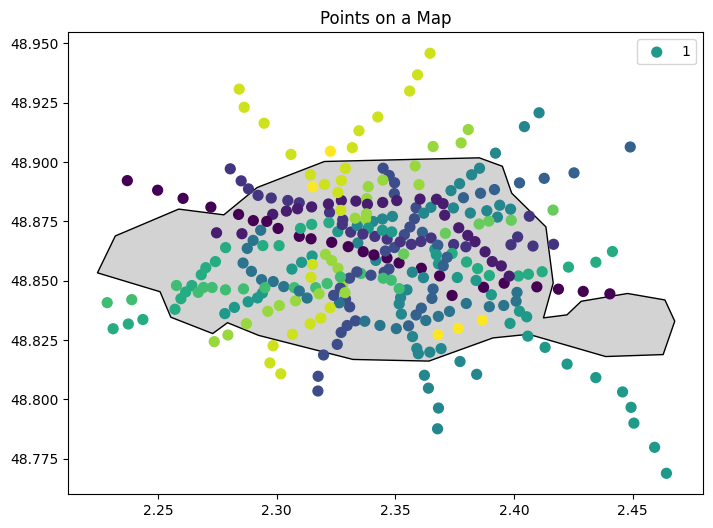

In [ ]:
color = stations_gdf['lines'].apply(first_element)

paris = gpd.read_file("paris.geojson")

# Plot the world map
ax = paris.plot(figsize=(10, 6), color='lightgray', edgecolor='black')

# Plot the points on top of the map
stations_gdf.plot(ax=ax, marker='o', c=color, markersize=50)

# Add title and show the plot
plt.title("Points on a Map")
plt.legend(['1','2','3','4','5','7','8','9','10','11','12','13','14'])
plt.show()

In [94]:
station_coords[station_coords['latitude'] < 48.5]

,Station,latitude,longitude,lines
122,Malesherbes,48.293592,2.401134,[3]
